---

### Load Data

In [556]:
%load_ext autoreload
%autoreload 2

# import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plot

from etl.extract import ProjectZero

# import projectzero data
from etl.extract import ProjectZero
data = ProjectZero().get_data()

# df_model instance
df_nyc = data['ext_nyc']
df_seattle = data['ext_seattle'].copy()
pd.options.display.float_format = '{:.2f}'.format


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [557]:
# NYC columns
for i in list(df_nyc.columns):
    print(i)

Unnamed: 0
Order
Property Id
Property Name
Parent Property Id
Parent Property Name
BBL - 10 digits
NYC Borough, Block and Lot (BBL) self-reported
NYC Building Identification Number (BIN)
Address 1 (self-reported)
Address 2 (self-reported)
Postal Code
Street Number
Street Name
Borough
DOF Gross Floor Area (ft²)
Self-Reported Gross Floor Area (ft²)
Primary Property Type - Self Selected
List of All Property Use Types at Property
Largest Property Use Type
Largest Property Use Type - Gross Floor Area (ft²)
2nd Largest Property Use Type
2nd Largest Property Use - Gross Floor Area (ft²)
3rd Largest Property Use Type
3rd Largest Property Use Type - Gross Floor Area (ft²)
Year Built
Number of Buildings
Occupancy
Metered Areas (Energy)
Metered Areas  (Water)
ENERGY STAR Score
Source EUI (kBtu/ft²)
Weather Normalized Source EUI (kBtu/ft²)
Site EUI (kBtu/ft²)
Weather Normalized Site EUI (kBtu/ft²)
Weather Normalized Site Electricity Intensity (kWh/ft²)
Weather Normalized Site Natural Gas Intensity

In [558]:
# Seattle Columns
for i in list(df_seattle.columns):
    print(i)

OSEBuildingID
DataYear
BuildingType
PrimaryPropertyType
PropertyName
TaxParcelIdentificationNumber
Location
CouncilDistrictCode
Neighborhood
YearBuilt
NumberofBuildings
NumberofFloors
PropertyGFATotal
PropertyGFAParking
PropertyGFABuilding(s)
ListOfAllPropertyUseTypes
LargestPropertyUseType
LargestPropertyUseTypeGFA
SecondLargestPropertyUseType
SecondLargestPropertyUseTypeGFA
ThirdLargestPropertyUseType
ThirdLargestPropertyUseTypeGFA
YearsENERGYSTARCertified
ENERGYSTARScore
SiteEUI(kBtu/sf)
SiteEUIWN(kBtu/sf)
SourceEUI(kBtu/sf)
SourceEUIWN(kBtu/sf)
SiteEnergyUse(kBtu)
SiteEnergyUseWN(kBtu)
SteamUse(kBtu)
Electricity(kWh)
Electricity(kBtu)
NaturalGas(therms)
NaturalGas(kBtu)
OtherFuelUse(kBtu)
GHGEmissions(MetricTonsCO2e)
GHGEmissionsIntensity(kgCO2e/ft2)
DefaultData
Comment
ComplianceStatus
Outlier
2010 Census Tracts
Seattle Police Department Micro Community Policing Plan Areas
City Council Districts
SPD Beats
Zip Codes


In [559]:
seattle_features = [
    'PrimaryPropertyType',
    'NumberofFloors',
    'PropertyGFABuilding(s)',
    'PropertyGFAParking',
    'YearBuilt',
    'BuildingType',
    'Electricity(kWh)']

df_seattle = df_seattle[seattle_features]

nyc_features = [
    'Primary Property Type - Self Selected',
    'Self-Reported Gross Floor Area (ft²)',
    'Year Built',
    'Electricity Use - Grid Purchase (kWh)',
    'Occupancy',
    'Number of Buildings'
]

df_nyc = df_nyc[nyc_features]

# rename nyc columns to match seattle
df_nyc_renamed = df_nyc.rename(columns={
    'Primary Property Type - Self Selected': 'PrimaryPropertyType' ,
    'Self-Reported Gross Floor Area (ft²)': 'PropertyGFABuilding(s)',
    'Year Built': 'YearBuilt',
    'Electricity Use - Grid Purchase (kWh)': 'Electricity(kWh)',
})

# Concatenate the two DataFrames
merged_df = pd.concat([df_nyc_renamed, df_seattle])

merged_df.isna().sum()
cities_df = merged_df

df_nyc_renamed.dropna(subset=['Electricity(kWh)'], inplace=True)

In [560]:
df_nyc_renamed['PrimaryPropertyType'].unique()
    

array(['Office', 'K-12 School', 'Hotel', 'Worship Facility',
       'Multifamily Housing', 'Distribution Center',
       'Refrigerated Warehouse', 'Manufacturing/Industrial Plant',
       'Hospital (General Medical & Surgical)', 'Other',
       'Other - Education', 'Museum',
       'Other - Entertainment/Public Assembly', 'Retail Store',
       'College/University', 'Mixed Use Property', 'Food Service',
       'Non-Refrigerated Warehouse', 'Residence Hall/Dormitory',
       'Laboratory', 'Medical Office',
       'Urgent Care/Clinic/Other Outpatient',
       'Ambulatory Surgical Center', 'Other - Mall',
       'Senior Care Community', 'Pre-school/Daycare',
       'Social/Meeting Hall', 'Performing Arts',
       'Other - Lodging/Residential', 'Other - Specialty Hospital',
       'Self-Storage Facility', 'Financial Office', 'Strip Mall',
       'Prison/Incarceration', 'Fitness Center/Health Club/Gym',
       'Parking', 'Bank Branch', 'Wholesale Club/Supercenter',
       'Data Center', 'Ot

In [561]:
# Encode 'PrimaryPropertyType' using one-hot encoding
encoded_df = pd.get_dummies(df_nyc_renamed, columns=['PrimaryPropertyType'], prefix='BuildingType')

# Calculate the correlation matrix
correlation_matrix = encoded_df.corr()

# Extract correlations related to 'Electricity(kWh)'
correlation_with_electricity = correlation_matrix['Electricity(kWh)']

# Create a DataFrame with correlations
correlation_df = pd.DataFrame({'BuildingType': correlation_with_electricity.index, 'Correlation': correlation_with_electricity.values})

# Sort correlations in descending order
sorted_correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

# filter high correlation
sorted_correlation_df = sorted_correlation_df[(sorted_correlation_df['Correlation'] > 0.01) | (sorted_correlation_df['Correlation'] < -0.01)]

# Show only newly created building type features
sorted_correlation_df = sorted_correlation_df[~sorted_correlation_df['BuildingType'].isin(df_nyc_renamed.columns)]
sorted_correlation_df

,BuildingType,Correlation
70,BuildingType_Wastewater Treatment Plant,0.25
35,BuildingType_Office,0.23
21,BuildingType_Hospital (General Medical & Surgi...,0.17
13,BuildingType_Data Center,0.11
16,BuildingType_Financial Office,0.10
45,BuildingType_Other - Specialty Hospital,0.09
25,BuildingType_Laboratory,0.08
9,BuildingType_College/University,0.04
22,BuildingType_Hotel,0.04
33,BuildingType_Museum,0.04


In [562]:
# saving buildings with high correlation in a list
high_correlation = list(sorted_correlation_df['BuildingType'])
high_correlation = [building.replace('BuildingType_','') for building in high_correlation]


# filter to show only those with high correlations
df_nyc_renamed = df_nyc_renamed[df_nyc_renamed.PrimaryPropertyType.isin(high_correlation)] 
df_nyc_renamed

,PrimaryPropertyType,PropertyGFABuilding(s),YearBuilt,Electricity(kWh),Occupancy,Number of Buildings
0,Office,169416,1909,1920103.60,95,1
1,K-12 School,94380,1963,180640.00,100,1
2,Hotel,125000,1999,2354605.30,85,1
3,Hotel,50000,1994,579335.20,100,1
4,Hotel,50000,2012,299809.90,0,1
...,...,...,...,...,...,...
34349,Self-Storage Facility,69050,2008,123163.60,80,1
34350,Multifamily Housing,32800,1931,92768.00,100,1
34351,Multifamily Housing,32350,1925,81381.00,100,1
34352,Multifamily Housing,33800,1926,184548.00,100,1


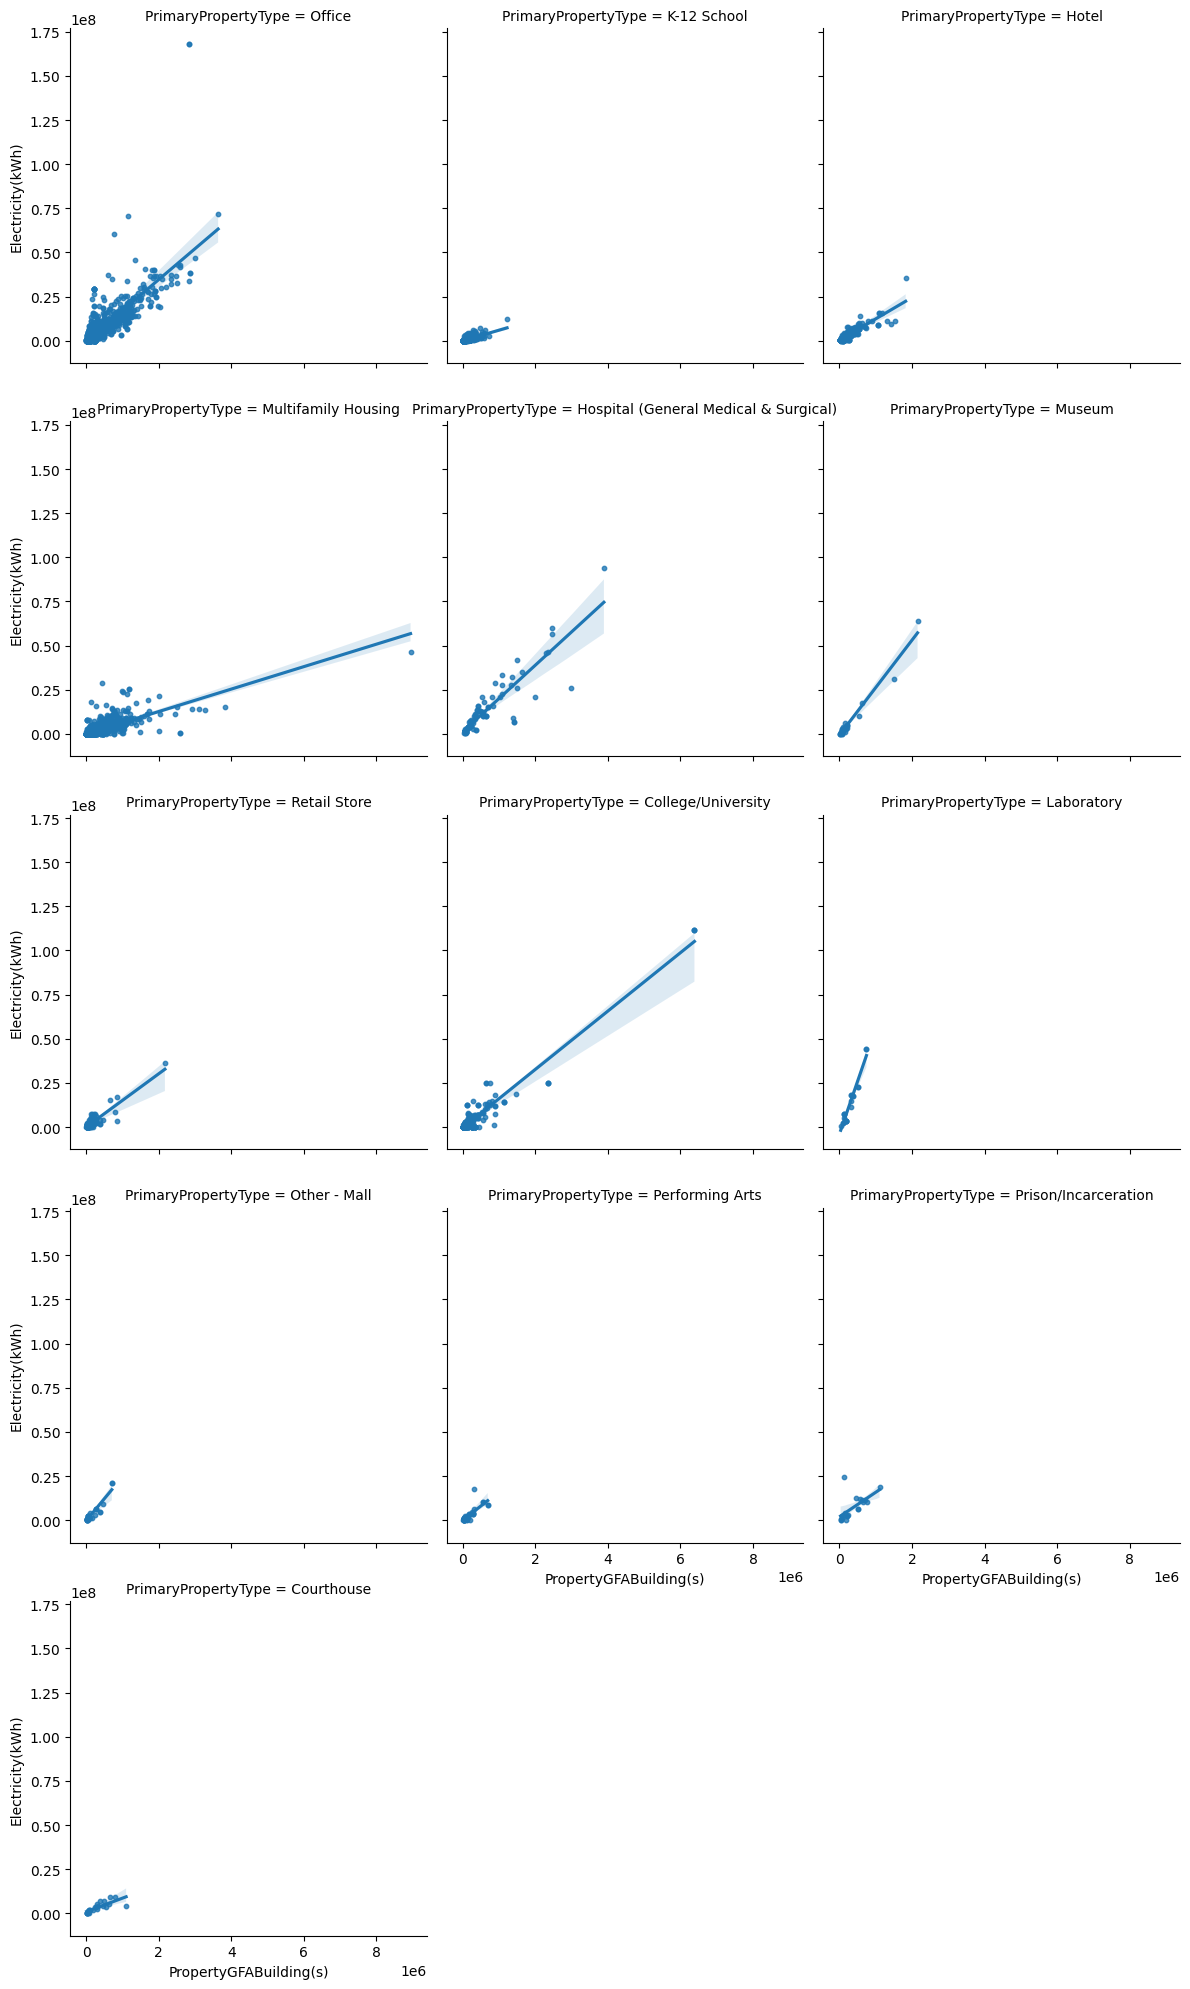

In [563]:
# Regressing GFA to Electricty consumption by filtered property type
drop_types = [
    'Fire Station',
    'Transportation Terminal/Station',
    'Movie Theater',
    'Supermarket/Grocery Store',
    'Outpatient Rehabilitation/Physical Therapy',
    'Data Center',
    'Wholesale Club/Supercenter',
    'Ambulatory Surgical Center',
    'Pre-school/Daycare',
    'Worship Facility',
    'Other - Specialty Hospital',
    'Senior Care Community',
    'Residence Hall/Dormitory',
    'Self-Storage Facility',
    'Parking',
    'Stadium (Open)',
    'Other',
    'Mixed Use Property',
    'Enclosed Mall',
    'Wastewater Treatment Plant',
    'Other - Entertainment/Public Assembly',
    'Non-Refrigerated Warehouse',
    'Financial Office'
]

df_nyc_renamed = df_nyc_renamed[~df_nyc_renamed.PrimaryPropertyType.isin(drop_types)]
g = sns.FacetGrid(data=df_nyc_renamed,col='PrimaryPropertyType',col_wrap=3, height=4)
g.map(sns.regplot, 'PropertyGFABuilding(s)', 'Electricity(kWh)', scatter_kws={'s': 10})

In [564]:
#dropping huge outliers
df_nyc_renamed = df_nyc_renamed[~((df_nyc_renamed['Electricity(kWh)'] > 50000000) | (df_nyc_renamed['PropertyGFABuilding(s)'] > 3000000))]

# dropping outliers by typology
# K-12 School
df_nyc_renamed = df_nyc_renamed[~((df_nyc_renamed['PrimaryPropertyType'] == 'K-12 School') & (df_nyc_renamed['PropertyGFABuilding(s)'] > 800000))]

# Hotel
df_nyc_renamed = df_nyc_renamed[~((df_nyc_renamed['PrimaryPropertyType'] == 'Hotel') & (df_nyc_renamed['PropertyGFABuilding(s)'] > 100000))]
df_nyc_renamed = df_nyc_renamed[~((df_nyc_renamed['PrimaryPropertyType'] == 'Hotel') & (df_nyc_renamed['PropertyGFABuilding(s)'] < 20000))]
df_nyc_renamed = df_nyc_renamed[~((df_nyc_renamed['PrimaryPropertyType'] == 'Hotel') & (df_nyc_renamed['Electricity(kWh)'] > 3000000))]

# Multifamily Housing
df_nyc_renamed = df_nyc_renamed[~((df_nyc_renamed['PrimaryPropertyType'] == 'Multifamily Housing') & (df_nyc_renamed['PropertyGFABuilding(s)'] > 2000000))]
df_nyc_renamed = df_nyc_renamed[~((df_nyc_renamed['PrimaryPropertyType'] == 'Multifamily Housing') & (df_nyc_renamed['Electricity(kWh)'] > 14000000))]
df_nyc_renamed = df_nyc_renamed[~((df_nyc_renamed['PrimaryPropertyType'] == 'Multifamily Housing') & (df_nyc_renamed['Electricity(kWh)'] < 2000000) & (df_nyc_renamed['PropertyGFABuilding(s)'] > 700000) )]

# Hospital (General Medical & Surgical)
df_nyc_renamed = df_nyc_renamed[~((df_nyc_renamed['PrimaryPropertyType'] == 'Hospital (General Medical & Surgical)') & (df_nyc_renamed['Electricity(kWh)'] < 20000000) & (df_nyc_renamed['PropertyGFABuilding(s)'] > 1300000) )]
df_nyc_renamed = df_nyc_renamed[~((df_nyc_renamed['PrimaryPropertyType'] == 'Hospital (General Medical & Surgical)') & (df_nyc_renamed['Electricity(kWh)'] < 30000000) & (df_nyc_renamed['PropertyGFABuilding(s)'] > 1700000) )]

# Museum
df_nyc_renamed = df_nyc_renamed[~((df_nyc_renamed['PrimaryPropertyType'] == 'Museum') & (df_nyc_renamed['PropertyGFABuilding(s)'] > 500000))]

# Retail Store
# df_nyc_renamed = df_nyc_renamed[~((df_nyc_renamed['PrimaryPropertyType'] == 'Retail Store') & (df_nyc_renamed['PropertyGFABuilding(s)'] > 500000))]

# College/University
df_nyc_renamed = df_nyc_renamed[~((df_nyc_renamed['PrimaryPropertyType'] == 'College/University') & (df_nyc_renamed['Electricity(kWh)'] > 20000000))]
df_nyc_renamed = df_nyc_renamed[~((df_nyc_renamed['PrimaryPropertyType'] == 'College/University') & (df_nyc_renamed['Electricity(kWh)'] < 5000000) & (df_nyc_renamed['PropertyGFABuilding(s)'] > 249000) )]
df_nyc_renamed = df_nyc_renamed[~((df_nyc_renamed['PrimaryPropertyType'] == 'College/University') & (df_nyc_renamed['Electricity(kWh)'] > 10000000) & (df_nyc_renamed['PropertyGFABuilding(s)'] < 500000) )]

# Performing Arts
df_nyc_renamed = df_nyc_renamed[~((df_nyc_renamed['PrimaryPropertyType'] == 'Performing Arts') & (df_nyc_renamed['Electricity(kWh)'] > 15000000))]

# Prison/Incarceration
df_nyc_renamed = df_nyc_renamed[~((df_nyc_renamed['PrimaryPropertyType'] == 'Prison/Incarceration') & (df_nyc_renamed['Electricity(kWh)'] > 20000000))]

# Courthouse
df_nyc_renamed = df_nyc_renamed[~((df_nyc_renamed['PrimaryPropertyType'] == 'Courthouse') & (df_nyc_renamed['PropertyGFABuilding(s)'] > 1000000))]






In [565]:
import plotly.express as px

px.scatter(df_nyc_renamed, x='PropertyGFABuilding(s)', y='Electricity(kWh)', color='PrimaryPropertyType')


In [566]:
for i in df_nyc_renamed.PrimaryPropertyType.unique():
    print(i)

Office
K-12 School
Hotel
Multifamily Housing
Hospital (General Medical & Surgical)
Museum
Retail Store
College/University
Laboratory
Other - Mall
Performing Arts
Prison/Incarceration
Courthouse


### Encoding and Scaling

In [567]:
df_nyc_renamed.head(3)

,PrimaryPropertyType,PropertyGFABuilding(s),YearBuilt,Electricity(kWh),Occupancy,Number of Buildings
0,Office,169416,1909,1920103.60,95,1
1,K-12 School,94380,1963,180640.00,100,1
3,Hotel,50000,1994,579335.20,100,1


In [568]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse_output= False) 

# Fit encoder
ohe.fit(df_nyc_renamed[['PrimaryPropertyType']])

# Transform the current "Street" column
df_nyc_renamed[ohe.get_feature_names_out()] = ohe.transform(df_nyc_renamed[['PrimaryPropertyType']])

# Drop the column "Street" which has been encoded
df_nyc_renamed.drop(columns = ['PrimaryPropertyType'], inplace = True)

df_nyc_renamed.head(3)

,PropertyGFABuilding(s),YearBuilt,Electricity(kWh),Occupancy,Number of Buildings,PrimaryPropertyType_College/University,PrimaryPropertyType_Courthouse,PrimaryPropertyType_Hospital (General Medical & Surgical),PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Multifamily Housing,PrimaryPropertyType_Museum,PrimaryPropertyType_Office,PrimaryPropertyType_Other - Mall,PrimaryPropertyType_Performing Arts,PrimaryPropertyType_Prison/Incarceration,PrimaryPropertyType_Retail Store
0,169416,1909,1920103.60,95,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
1,94380,1963,180640.00,100,1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,50000,1994,579335.20,100,1,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [569]:
from sklearn.preprocessing import OrdinalEncoder

# finding string features to encode
nan_features = [i for i in df_nyc_renamed.columns if df_nyc_renamed[i].dtype == 'object']

# Instantiate Ordinal Encoder
ordinal_encoder = OrdinalEncoder()

# Fit to features
df_encoded = df_nyc_renamed.copy()
ordinal_encoder.fit(df_encoded[nan_features])

# Transforming categories into ordered numbers
df_encoded[nan_features] = ordinal_encoder.transform(df_encoded[nan_features])
df_encoded.head(3)



,PropertyGFABuilding(s),YearBuilt,Electricity(kWh),Occupancy,Number of Buildings,PrimaryPropertyType_College/University,PrimaryPropertyType_Courthouse,PrimaryPropertyType_Hospital (General Medical & Surgical),PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Multifamily Housing,PrimaryPropertyType_Museum,PrimaryPropertyType_Office,PrimaryPropertyType_Other - Mall,PrimaryPropertyType_Performing Arts,PrimaryPropertyType_Prison/Incarceration,PrimaryPropertyType_Retail Store
0,169416,1909,1920103.60,95,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
1,94380,1963,180640.00,100,1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,50000,1994,579335.20,100,1,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [570]:
from sklearn.preprocessing import StandardScaler

# drop property type columns
# df_seattle.drop(columns='PrimaryPropertyType', inplace=True)

# instantiate scaler
s_scaler = StandardScaler()

# instantiate scaled df before transform
df_scaled = df_encoded.copy().dropna()

# define numerical features 
numerical_features = list(df_scaled.columns)
numerical_features.remove('Electricity(kWh)') # remove target before scaling

# fit scaler
s_scaler.fit(df_scaled[numerical_features])

# apply tranform to features
df_scaled[numerical_features] = s_scaler.transform(df_scaled[numerical_features])
df_scaled.head(3)

,PropertyGFABuilding(s),YearBuilt,Electricity(kWh),Occupancy,Number of Buildings,PrimaryPropertyType_College/University,PrimaryPropertyType_Courthouse,PrimaryPropertyType_Hospital (General Medical & Surgical),PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Multifamily Housing,PrimaryPropertyType_Museum,PrimaryPropertyType_Office,PrimaryPropertyType_Other - Mall,PrimaryPropertyType_Performing Arts,PrimaryPropertyType_Prison/Incarceration,PrimaryPropertyType_Retail Store
0,0.36,-1.14,1920103.60,-0.60,-0.06,-0.16,-0.03,-0.06,-0.09,-0.24,-0.03,-1.95,-0.03,3.02,-0.04,-0.05,-0.03,-0.10
1,-0.10,0.58,180640.00,0.17,-0.06,-0.16,-0.03,-0.06,-0.09,4.12,-0.03,-1.95,-0.03,-0.33,-0.04,-0.05,-0.03,-0.10
3,-0.38,1.57,579335.20,0.17,-0.06,-0.16,-0.03,-0.06,10.59,-0.24,-0.03,-1.95,-0.03,-0.33,-0.04,-0.05,-0.03,-0.10


### Training Model

In [571]:
X = df_scaled[numerical_features]
y = df_scaled['Electricity(kWh)']

from sklearn.linear_model import Ridge, Lasso, LinearRegression

linreg = LinearRegression().fit(X, y)
ridge = Ridge(alpha=0.2).fit(X, y)
lasso = Lasso(alpha=0.2).fit(X, y)

coefs = pd.DataFrame({
    "coef_linreg": pd.Series(linreg.coef_, index = X.columns),
    "coef_ridge": pd.Series(ridge.coef_, index = X.columns),
    "coef_lasso": pd.Series(lasso.coef_, index= X.columns)})\

coefs\
    .applymap(lambda x: int(x))\
    .style.applymap(lambda x: 'color: red' if x == 0 else 'color: white')

coefs.sort_values('coef_linreg', ascending=False, inplace=True)
coefs.head(50)

c:\Users\hramzan\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.393e+14, tolerance: 1.690e+13



,coef_linreg,coef_ridge,coef_lasso
PropertyGFABuilding(s),1909414.61,1909399.65,1909414.51
PrimaryPropertyType_Office,288783.47,288784.62,203811.82
PrimaryPropertyType_Hospital (General Medical & Surgical),283524.13,283523.60,267717.93
PrimaryPropertyType_Laboratory,269620.15,269618.52,261521.72
Occupancy,88581.27,88579.78,88581.02
PrimaryPropertyType_Other - Mall,55289.02,55288.53,43840.83
PrimaryPropertyType_Prison/Incarceration,41696.87,41697.13,34170.41
PrimaryPropertyType_Retail Store,38120.22,38119.69,10192.39
PrimaryPropertyType_Museum,34053.20,34052.90,25249.93
PrimaryPropertyType_College/University,33612.17,33611.76,-11178.25


In [577]:
# import model type
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Instantiate model 
sgd_regressor = SGDRegressor(penalty='l1',random_state=3, alpha=0.1, max_iter=10000)

# define x and y 
new_features = list(df_scaled.columns)
new_features.remove('Electricity(kWh)')

X = df_scaled[new_features]
y = df_scaled['Electricity(kWh)']

# train model 

scores = cross_val_score(sgd_regressor, X, y, cv=3)
r2_score = pd.DataFrame({'score': scores.mean()}, index=[0])
r2_score

,score
0,0.60


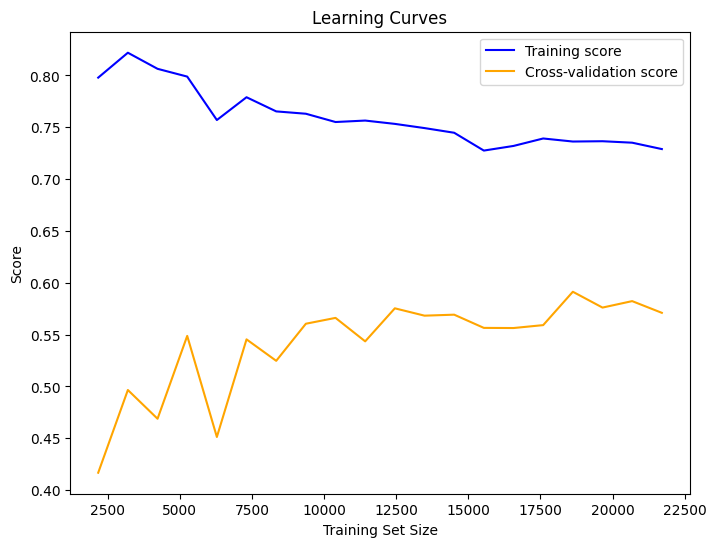

In [575]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=estimator, X=X, y=y, cv=cv, train_sizes=np.linspace(0.1, 1.0, 20)
    )

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, color="blue", label="Training score")
    plt.plot(train_sizes, test_mean, color="orange", label="Cross-validation score")
    plt.title("Learning Curves")
    plt.xlabel("Training Set Size")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

# Usage:
plot_learning_curve(sgd_regressor, X, y)